This dataset is designed for predicting food delivery times based on various influencing factors such as distance, weather, traffic conditions, and time of day. It offers a practical and engaging challenge for machine learning practitioners, especially those interested in logistics and operations research.

Key Features:

Order_ID: Unique identifier for each order.

Distance_km: The delivery distance in kilometers.

Weather: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.

Traffic_Level: Traffic conditions categorized as Low, Medium, or High.

Time_of_Day: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.

Vehicle_Type: Type of vehicle used for delivery, including Bike, Scooter, and Car.

Preparation_Time_min: The time required to prepare the order, measured in minutes.

Courier_Experience_yrs: Experience of the courier in years.

Delivery_Time_min: The total delivery time in minutes (target variable).

Objectives: Predicting food delivery times.

*   **Improve Customer Satisfaction:** Provide accurate delivery time estimates manages customer expectations and reduce frustration.
*   **Optimize Operations:** Streamline delivery routes, allocate resources efficiently (vehicles and couriers), and balance workloads to achieve cost savings and faster service.
*   **Enhance Decision Making:** Supply data-driven insights for strategic planning, including service area selection, staffing requirements, and pricing strategies.
*   **Reduce Delivery Issues:** Anticipate potential delays caused by factors such as traffic or adverse weather, enabling proactive measures to maintain on-time delivery and service reliability.

Key Questions:

1. How does the delivery distance (`Distance_km`) relate to the `Delivery_Time_min`?
2. What is the distribution of delivery times across different `Weather` conditions and `Traffic_Level`?
3. Is there a significant difference in `Delivery_Time_min` based on the `Vehicle_Type` used?
4. How does the `Time_of_Day` affect the `Delivery_Time_min`?
5. Does the `Courier_Experience_yrs` have an impact on the `Delivery_Time_min`?

# Import Libraries

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from scipy.stats import (chi2_contingency, pointbiserialr,)
from scipy.stats.contingency import (association,)

import shap

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder,)
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from tabulate import tabulate

In [4]:
sns.set_style({
  'axes.facecolor': '#f3f3f3ff',
  'figure.facecolor': '#f3f3f3ff',
})

# Set the maximum number of columns and rows to display to a large number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Preprocessing

In [5]:
df = pd.read_csv('Food_Delivery_Times.csv')

In [ ]:
# Show 5 sample data
df.sample(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
621,158,15.35,Foggy,Low,Morning,Car,5,3.0,56
532,623,7.72,Rainy,Medium,Morning,Bike,11,NaN,36
487,330,5.33,Clear,Low,Evening,Car,29,1.0,51
540,189,10.83,Clear,Medium,Evening,Scooter,8,9.0,51
253,895,13.53,Rainy,Low,Evening,Bike,28,8.0,78


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


There are missing values in Weather, Traffic_Level, Time_of_Day, and Courier_Experience_yrs columns.

In [6]:
# Change Order_ID column data type into object
df['Order_ID'] = df['Order_ID'].astype('object')

In [7]:
# Define categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Exclude Order_ID columns from categorical data
categorical_cols = categorical_cols.drop('Order_ID')
categorical_cols

Index(['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], dtype='object')

In [8]:
# Define numerical columns
numerical_cols = df.select_dtypes(exclude='object').columns
numerical_cols

Index(['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')

## Check duplicate data

In [ ]:
df.duplicated().sum()

np.int64(0)

There are no duplicate records.

## Check missing values

In [ ]:
# Check the unique value of each categorical column
for col in categorical_cols:
    print(f"{col}: {df[col].unique().tolist()}")

Weather: ['Windy', 'Clear', 'Foggy', 'Rainy', 'Snowy', nan]
Traffic_Level: ['Low', 'Medium', 'High', nan]
Time_of_Day: ['Afternoon', 'Evening', 'Night', 'Morning', nan]
Vehicle_Type: ['Scooter', 'Bike', 'Car']


In [ ]:
# Check the missing value percentage of each column
for col in df.columns:
    print(f"The percentage of missing values of {col}: {df[col].isna().sum()/len(df)*100:.2f}%")

The percentage of missing values of Order_ID: 0.00%
The percentage of missing values of Distance_km: 0.00%
The percentage of missing values of Weather: 3.00%
The percentage of missing values of Traffic_Level: 3.00%
The percentage of missing values of Time_of_Day: 3.00%
The percentage of missing values of Vehicle_Type: 0.00%
The percentage of missing values of Preparation_Time_min: 0.00%
The percentage of missing values of Courier_Experience_yrs: 3.00%
The percentage of missing values of Delivery_Time_min: 0.00%


There are 3% missing values in columns Weather, Traffic_Level, Time_of_Day, and Courier_Experience_yrs, which will be handled after the data split.

## Check outliers

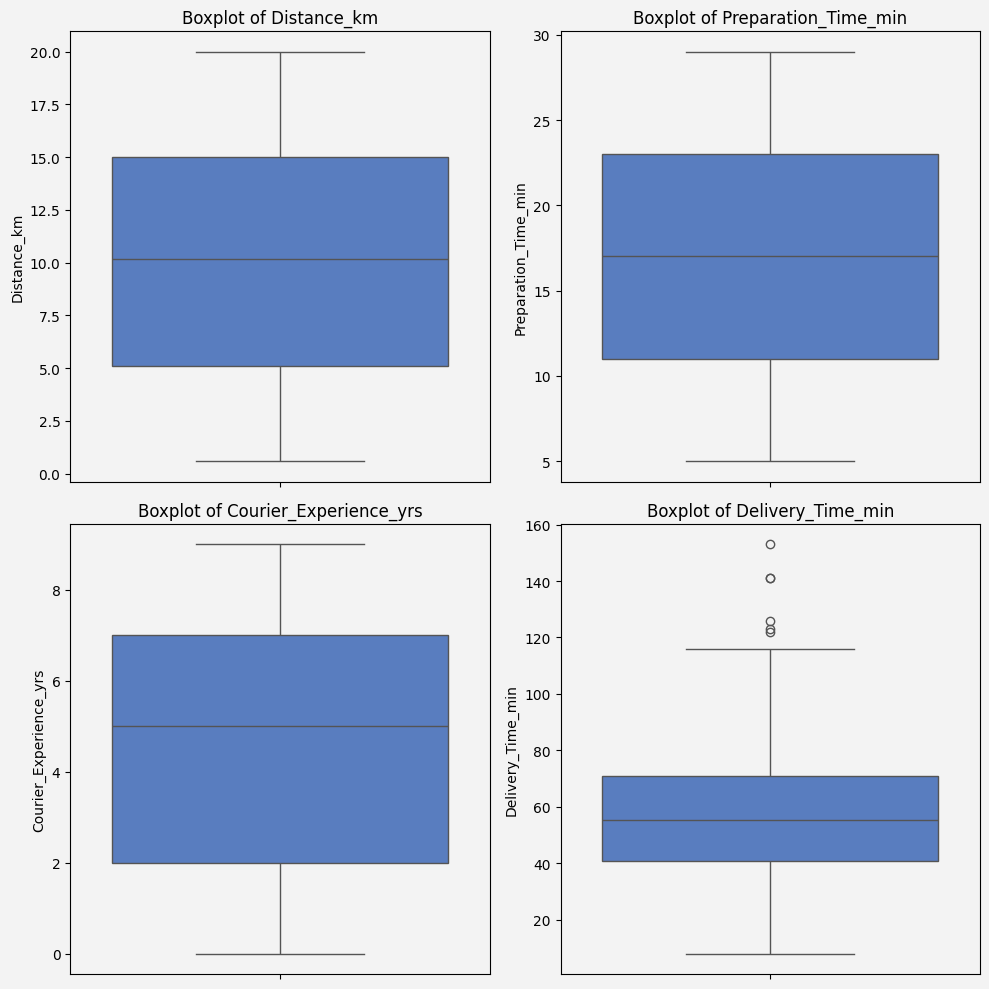

In [ ]:
# Select the numerical columns
# Create a 2x2 grid for 4 plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

# Plot each boxplot
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], palette='muted', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

# Turn off unused axes if any
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are no outliers that need to be handled.

# EDA

## Check data distribution

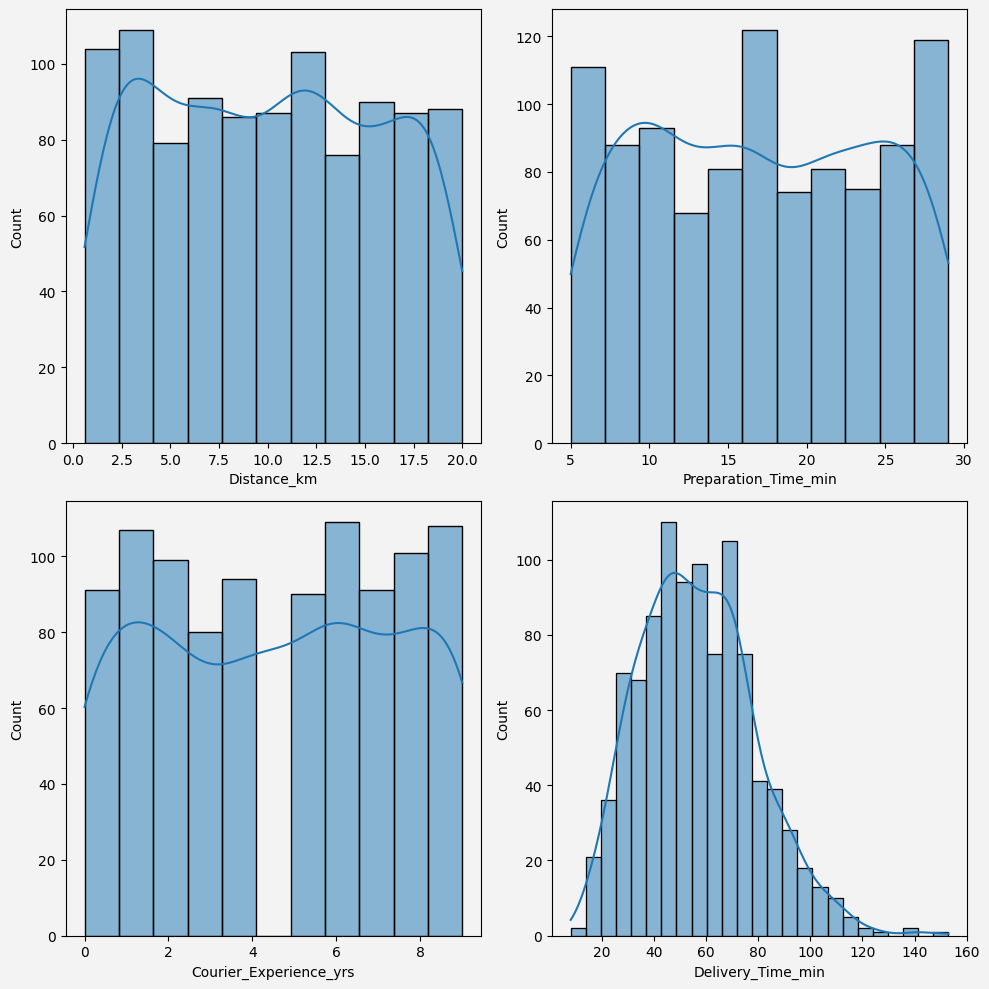

In [ ]:
# Select the numerical columns
# Create a 2x2 grid for 4 plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])

# Turn off unused axes if any
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. The delivery distances are fairly spread out, with subtle peaks around 2.5 km and 12.5 km.
2. Most orders are prepared within 10–25 minutes, peaking around 15 minutes.
3. Courier experience is quite evenly distributed, with slight peaks around 6 years.
4. The delivery time is right-skewed, with most deliveries taking 30–80 minutes, peaking around 50 minutes.

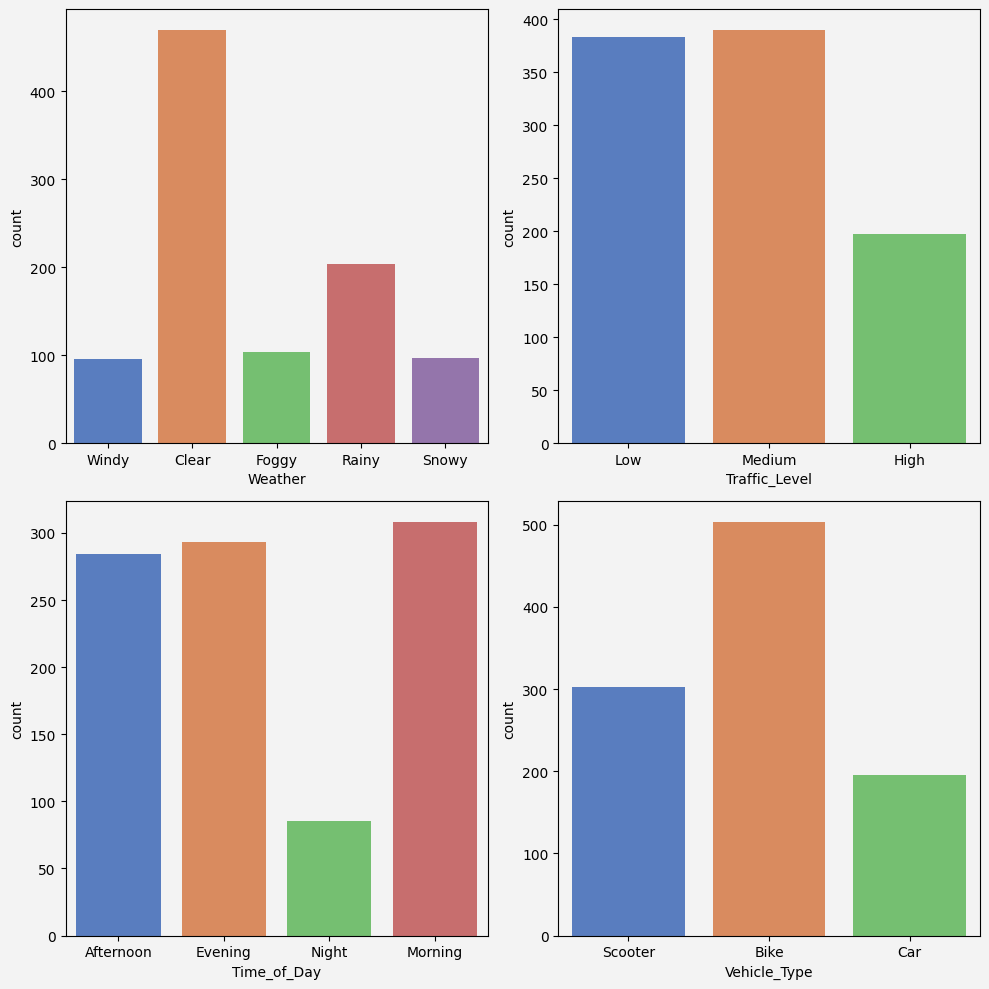

In [ ]:
# Select the categorical columns
# Create a 2x2 grid for 4 plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(categorical_cols):
    sns.countplot(df, x=col, hue=col, palette='muted', ax=axes[i])
    if axes[i].legend_:
        axes[i].legend_.remove()

# Turn off unused axes if any
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. Clear weather dominates, which is great for delivery speed.
2. Low and Medium traffic are most common, while High traffic is less frequent.
3. Night deliveries are least common, possibly due to fewer orders or limited courier availability.
4. Bikes are the most used, followed by Scooters, then Cars.

## How does the delivery distance (`Distance_km`) relate to the `Delivery_Time_min`?

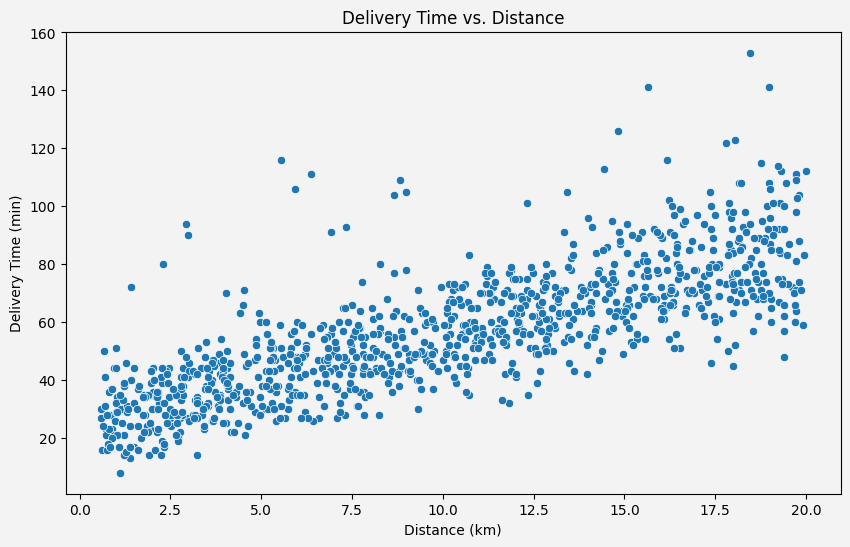


Correlation between Distance_km and Delivery_Time_min: 0.78


In [ ]:
# Plot the relationship between Distance_km and Delivery_Time_min
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distance_km', y='Delivery_Time_min', data=df)
plt.title('Delivery Time vs. Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.show()

# Calculate the correlation between Distance_km and Delivery_Time_min
correlation = df['Distance_km'].corr(df['Delivery_Time_min'])
print(f"\nCorrelation between Distance_km and Delivery_Time_min: {correlation:.2f}")

The correlation of 0.78 between Distance_km and Delivery_Time_min indicates a strong positive relationship.

## What is the distribution of delivery times across different `Weather` conditions and `Traffic_Level`?

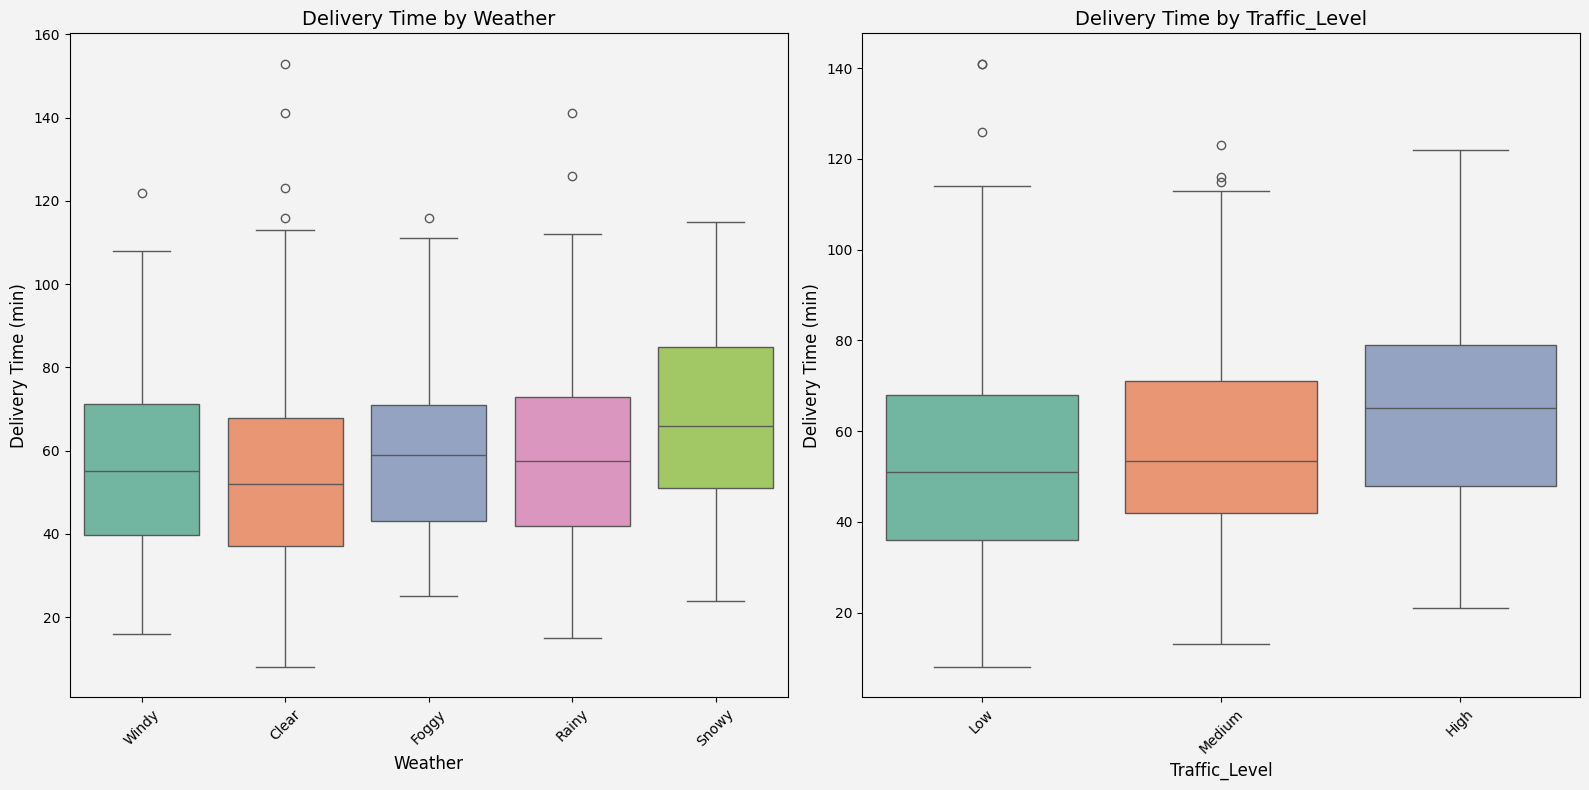

In [ ]:
# Create a 2x2 grid for the boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes = axes.flatten()

features = ['Weather', 'Traffic_Level']
# Loop through each categorical feature and plot
for i, feature in enumerate(features):
    sns.boxplot(x=feature, y='Delivery_Time_min', data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Delivery Time by {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Delivery Time (min)', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

1. Clear conditions lead to the fastest delivery times and Snowy weather show highest median, meaning deliveries take longer.
2. Low traffic yields the shortest delivery times.

## Is there a significant difference in `Delivery_Time_min` based on the `Vehicle_Type` used?

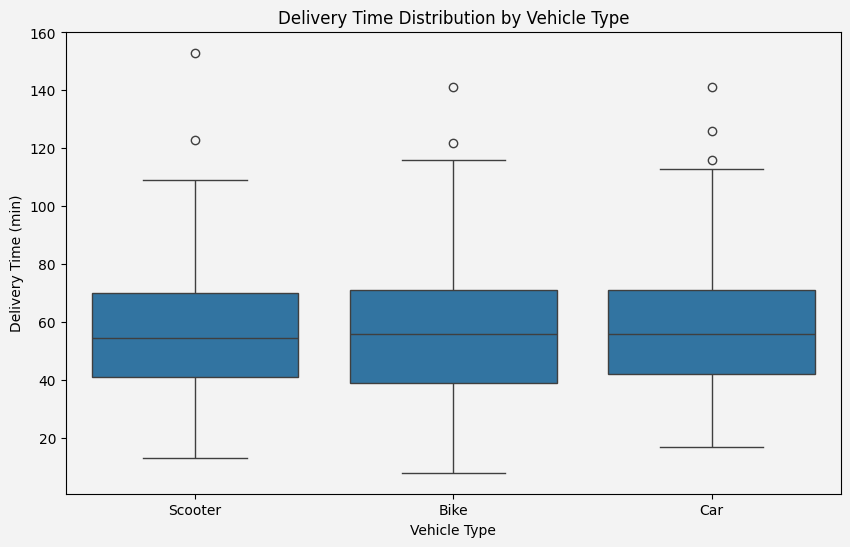

In [ ]:
# Create a box plot for Delivery_Time_min by Vehicle_Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vehicle_Type', y='Delivery_Time_min', data=df)
plt.title('Delivery Time Distribution by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Delivery Time (min)')
plt.show()

Scooter show the lowest median delivery time and the tightest spread, meaning they’re consistently fast and reliable.

## How does the `Time_of_Day` affect the `Delivery_Time_min`?

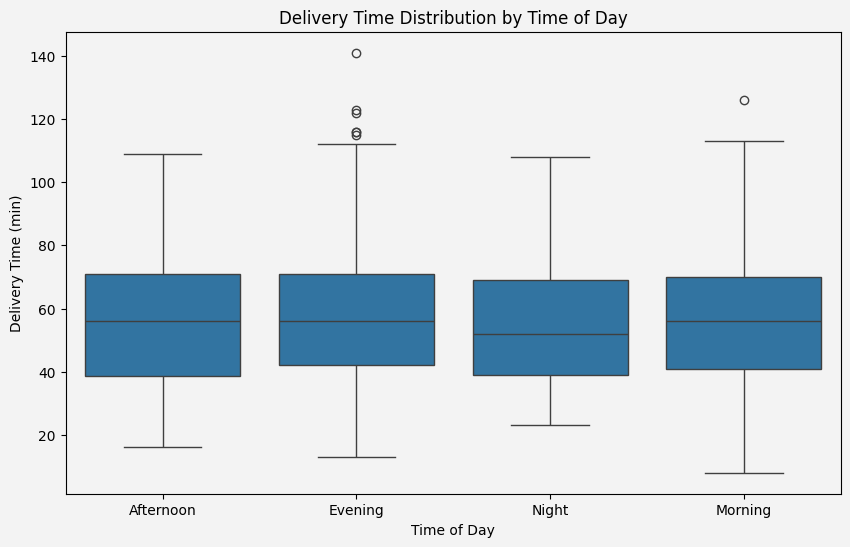

In [ ]:
# Create a box plot for Delivery_Time_min by Time_of_Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time_of_Day', y='Delivery_Time_min', data=df)
plt.title('Delivery Time Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Delivery Time (min)')
plt.show()

Night deliveries have slightly lower median times (~55 minutes).

## Does the `Courier_Experience_yrs` have an impact on the `Delivery_Time_min`?

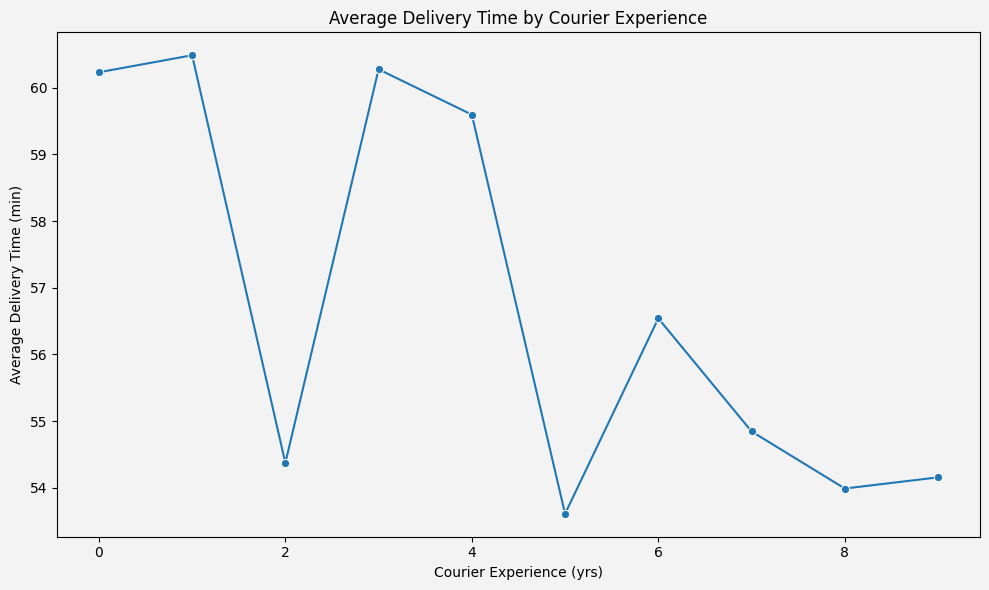

In [ ]:
# Group and calculate mean
experience_avg = df.groupby('Courier_Experience_yrs')['Delivery_Time_min'].mean().reset_index()

# Plot line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='Courier_Experience_yrs', y='Delivery_Time_min', data=experience_avg, marker='o')
plt.title('Average Delivery Time by Courier Experience')
plt.xlabel('Courier Experience (yrs)')
plt.ylabel('Average Delivery Time (min)')
plt.tight_layout()
plt.show()

Early experience shows a slight higher in average delivery time, peaking around year 2.

The overall range of average delivery time is narrow (about 53–61 minutes), suggesting that experience has a modest but noticeable effect.

## Split the Data

In [10]:
target_column = 'Delivery_Time_min'

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(columns=[target_column,'Order_ID']),
  df[target_column],
  test_size=0.2,
  random_state=42,
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 7), (200, 7), (800,), (200,))

In [ ]:
X_train.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
29,18.05,Clear,Medium,Evening,Scooter,10,7.0
535,2.14,Clear,High,Evening,Bike,18,3.0
695,3.23,Clear,High,Afternoon,Bike,17,9.0
557,7.51,Rainy,Low,Evening,Car,27,6.0
836,4.62,Rainy,Medium,Afternoon,Car,8,3.0


In [ ]:
# Statistical summary
X_train.describe()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs
count,800.00000,800.000000,776.000000
mean,10.10055,17.083750,4.606959
std,5.72590,7.227519,2.946649
min,0.59000,5.000000,0.000000
25%,5.13000,11.000000,2.000000
50%,10.22000,17.000000,5.000000
75%,14.94250,23.000000,7.000000
max,19.99000,29.000000,9.000000


## Handling Missing Values

### Categorical features

In [ ]:
# Display the mode of categorical features by vehicle type, because vehicle type is the only categorical feature with no missing values
for col in categorical_cols.drop('Vehicle_Type'):
    print(f"{col}: {X_train.groupby('Vehicle_Type')[col].apply(lambda x: x.mode()[0])}")

Weather: Vehicle_Type
Bike       Clear
Car        Clear
Scooter    Clear
Name: Weather, dtype: object
Traffic_Level: Vehicle_Type
Bike          Low
Car           Low
Scooter    Medium
Name: Traffic_Level, dtype: object
Time_of_Day: Vehicle_Type
Bike       Evening
Car        Morning
Scooter    Evening
Name: Time_of_Day, dtype: object


In [56]:
# Handle missing values for categorical feature using its mode per vehicle type
for col in categorical_cols.drop('Vehicle_Type'):
    for vehicle_type, group_train in X_train.groupby('Vehicle_Type'):
        mode_value = group_train[col].mode()
        if not mode_value.empty:
            X_train.loc[group_train.index, col] = X_train.loc[group_train.index, col].fillna(mode_value[0])
    for vehicle_type, group_test in X_test.groupby('Vehicle_Type'):
        mode_value = group_test[col].mode()
        if not mode_value.empty:
            X_test.loc[group_test.index, col] = X_test.loc[group_test.index, col].fillna(mode_value[0])

In [23]:
# Recheck missing values
for col in categorical_cols:
    print(f"{col}: {X_train[col].unique().tolist()}")

Weather: ['Clear', 'Rainy', 'Snowy', 'Windy', 'Foggy']
Traffic_Level: ['Medium', 'High', 'Low']
Time_of_Day: ['Evening', 'Afternoon', 'Morning', 'Night']
Vehicle_Type: ['Scooter', 'Bike', 'Car']


### Numerical feature

In [ ]:
# Display the median of Courier_Experience_yrs column by vehicle type
X_train.groupby('Vehicle_Type')['Courier_Experience_yrs'].median()

,Courier_Experience_yrs
Vehicle_Type,
Bike,5.0
Car,5.0
Scooter,5.0


In [ ]:
X_train['Courier_Experience_yrs'].median()

5.0

In [57]:
# Handle missing values for Courier_Experience_yrs column using its median
X_train['Courier_Experience_yrs'] = X_train['Courier_Experience_yrs'].fillna(X_train['Courier_Experience_yrs'].median())
X_test['Courier_Experience_yrs'] = X_test['Courier_Experience_yrs'].fillna(X_train['Courier_Experience_yrs'].median())

In [58]:
# Recheck missing values
X_train.isna().sum()

,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0


## Bivariate Analysis

### Category vs category

In [ ]:
def show_relationship_category_category(series1,
                                        series2,
                                        positive_class=None,
                                        return_result=False):
  df_temp = pd.crosstab(series1, series2)

  res = chi2_contingency(df_temp)
  coef = round(association(df_temp, method='cramer'), 2)

  if positive_class:
    df_temp[str(positive_class) + '_proba'] = \
      df_temp[positive_class] / (df_temp.sum(axis=1))

  if return_result:
    return (round(res.pvalue, 4), coef)

  print(series1.name, 'vs', series2.name)
  print('Chi2 Test p-Value      :', round(res.pvalue, 4))
  print('Cramer\'s V Coefficient :', coef)
  print(tabulate(
    df_temp,
    headers='keys',
    floatfmt=[''] + [',.0f'] * series2.unique().shape[0] + ['.1%'],
  ))

Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.



<Axes: ylabel='column1'>

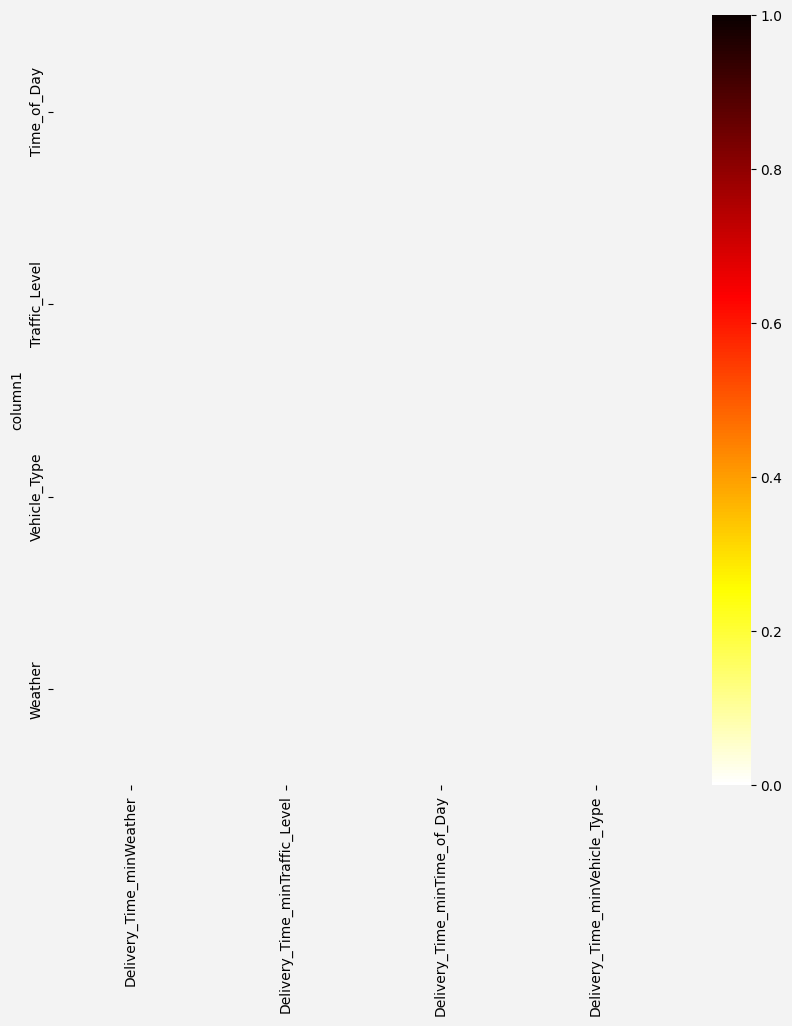

In [ ]:
corrs = [
  [], # column name 1
  [], # column name 2
  [], # p value
  [], # association strenght coefficient
]
for i in range(len(categorical_cols)):
  for j in range(i+1, len(categorical_cols)):
    pvalue, coef = show_relationship_category_category(
      df[categorical_cols[i]],
      df[categorical_cols[j]],
      return_result=True,
    )

    corrs[0].extend([categorical_cols[i], categorical_cols[j]])
    corrs[1].extend([categorical_cols[j], categorical_cols[i]])

    if i > j:
      corrs[2].extend([pvalue, None])
      corrs[3].extend([coef, None])
    else:
      corrs[2].extend([None, pvalue])
      corrs[3].extend([None, coef])

for i in range(len(categorical_cols)):
  pvalue, coef = show_relationship_category_category(
    df[categorical_cols[i]],
    df[target_column],
    return_result=True,
  )

  corrs[0].append(categorical_cols[i])
  corrs[1].append(target_column)
  corrs[2].append(pvalue)
  corrs[3].append(coef)

df_temp = pd.DataFrame({
  'column1': corrs[0],
  'column2': corrs[1],
  'pvalue': corrs[2],
  'coef': corrs[3],
})

df_temp['annot'] = np.where(
  df_temp['pvalue'].isnull(),
  None,
  np.where(
    df_temp['pvalue'] > 0.05,
    df_temp['coef'],
    df_temp['coef'].astype(str) + '*',
  ),
)

df_coef = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
  aggfunc='max',
)
df_coef = df_coef.reindex(columns = [target_column] + categorical_cols)

df_annot = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='annot',
  aggfunc='max',
)
df_annot = df_annot.reindex(columns = [target_column] + categorical_cols)

print('''Asterisk (*) indicates significant relationship between the two
variables based on Chi2 Test (p-value < 0.05). The number shown in each
cell is the relationship strength coefficient based on Cramer's V.
''')

# Create mask to hide the upper triangle
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(df_coef, dtype=bool))
# Plot heatmap with mask applied
sns.heatmap(
    df_coef,
    vmin=0,
    vmax=1,
    annot=df_annot,
    fmt='',
    cmap='hot_r',
    mask=mask
)

### Category vs numeric

In [ ]:
def show_relationship_numeric_category(series_numeric,
                                       series_category,
                                       return_result=False):
  if series_category.unique().shape[0] > 2:
    series_numeric_category = pd.qcut(series_numeric, 4, duplicates='drop')
    res = show_relationship_category_category(
      series_numeric_category,
      series_category,
      return_result=return_result,
    )
    if return_result:
      return res
  else:
    val_0 = series_category.min()
    val_1 = series_category.max()
    res = pointbiserialr(series_category == val_1, series_numeric)

    if return_result:
      return round(res.pvalue, 2), round(res.statistic, 2)

    print(series_numeric.name, 'vs', series_category.name)
    print('Point Biserial p-Value     :', round(res.pvalue, 2))
    print('Point Biserial Coefficient :', round(res.statistic, 2))
    sns.violinplot(
      x=series_numeric,
      hue=series_category,
      split=True,
      inner='quart',
      gap=0.1,
      palette='muted',
    )

Asterisk (*) indicates significant relationship (p-value < 0.05)
between the two variables based on:
- Point Biserial if number of distinct value in the category = 2;
- Chi2 Test if number of distinct value in the category > 2.

The number shown in each cell is the relationship strength coefficient
based on:
- Point Biserial if number of distinct value in the category = 2;
- Cramer's V if number of distinct value in the category > 2.



<Axes: ylabel='column1'>

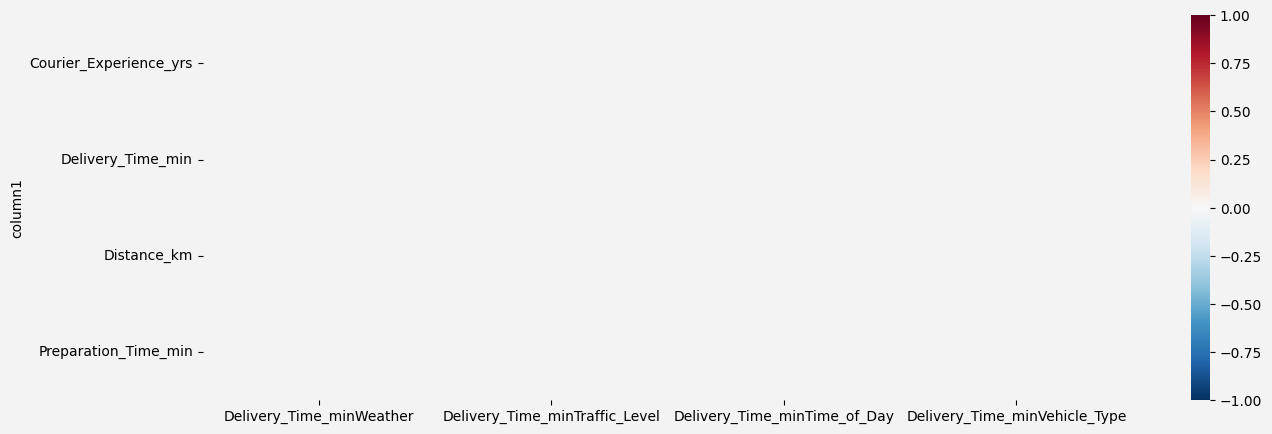

In [ ]:
corrs = [
  [], # column name 1
  [], # column name 2
  [], # p value
  [], # association strenght coefficient
]

for i in range(len(numerical_cols)):
  for j in range(len(categorical_cols)):
    pvalue, coef = show_relationship_numeric_category(
      df[numerical_cols[i]],
      df[categorical_cols[j]],
      return_result=True,
    )

    corrs[0].append(numerical_cols[i])
    corrs[1].append(categorical_cols[j])
    corrs[2].append(pvalue)
    corrs[3].append(coef)

for i in range(len(numerical_cols)):
  pvalue, coef = show_relationship_numeric_category(
    df[numerical_cols[i]],
    df[target_column],
    return_result=True,
  )

  corrs[0].append(numerical_cols[i])
  corrs[1].append(target_column)
  corrs[2].append(pvalue)
  corrs[3].append(coef)

df_temp = pd.DataFrame({
  'column1': corrs[0],
  'column2': corrs[1],
  'pvalue': corrs[2],
  'coef': corrs[3],
})

df_temp['annot'] = np.where(
  df_temp['pvalue'].isnull(),
  None,
  np.where(
    df_temp['pvalue'] > 0.05,
    df_temp['coef'],
    df_temp['coef'].astype(str) + '*',
  ),
)

df_coef = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
  aggfunc='max',
)
df_coef = df_coef.reindex(columns = [target_column] + categorical_cols)

df_annot = df_temp.pivot_table(
  index='column1',
  columns='column2',
  values='annot',
  aggfunc='max',
)
df_annot = df_annot.reindex(columns = [target_column] + categorical_cols)

print('''Asterisk (*) indicates significant relationship (p-value < 0.05)
between the two variables based on:
- Point Biserial if number of distinct value in the category = 2;
- Chi2 Test if number of distinct value in the category > 2.

The number shown in each cell is the relationship strength coefficient
based on:
- Point Biserial if number of distinct value in the category = 2;
- Cramer's V if number of distinct value in the category > 2.
''')
plt.figure(figsize=(15, 5))
sns.set_style({
  'axes.facecolor': '#f3f3f3ff',
  'figure.facecolor': '#f3f3f3ff',
})
sns.heatmap(
  df_coef,
  vmin = -1,
  vmax = 1,
  annot = df_annot,
  fmt = '',
  cmap = 'RdBu_r',
)

### Numeric vs numeric

In [ ]:
df_corr = df[numerical_cols].corr(method='spearman')
df_corr

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
Distance_km,1.000000,-0.009025,-0.007457,0.816535
Preparation_Time_min,-0.009025,1.000000,-0.030159,0.305535
Courier_Experience_yrs,-0.007457,-0.030159,1.000000,-0.086703
Delivery_Time_min,0.816535,0.305535,-0.086703,1.000000


<Axes: >

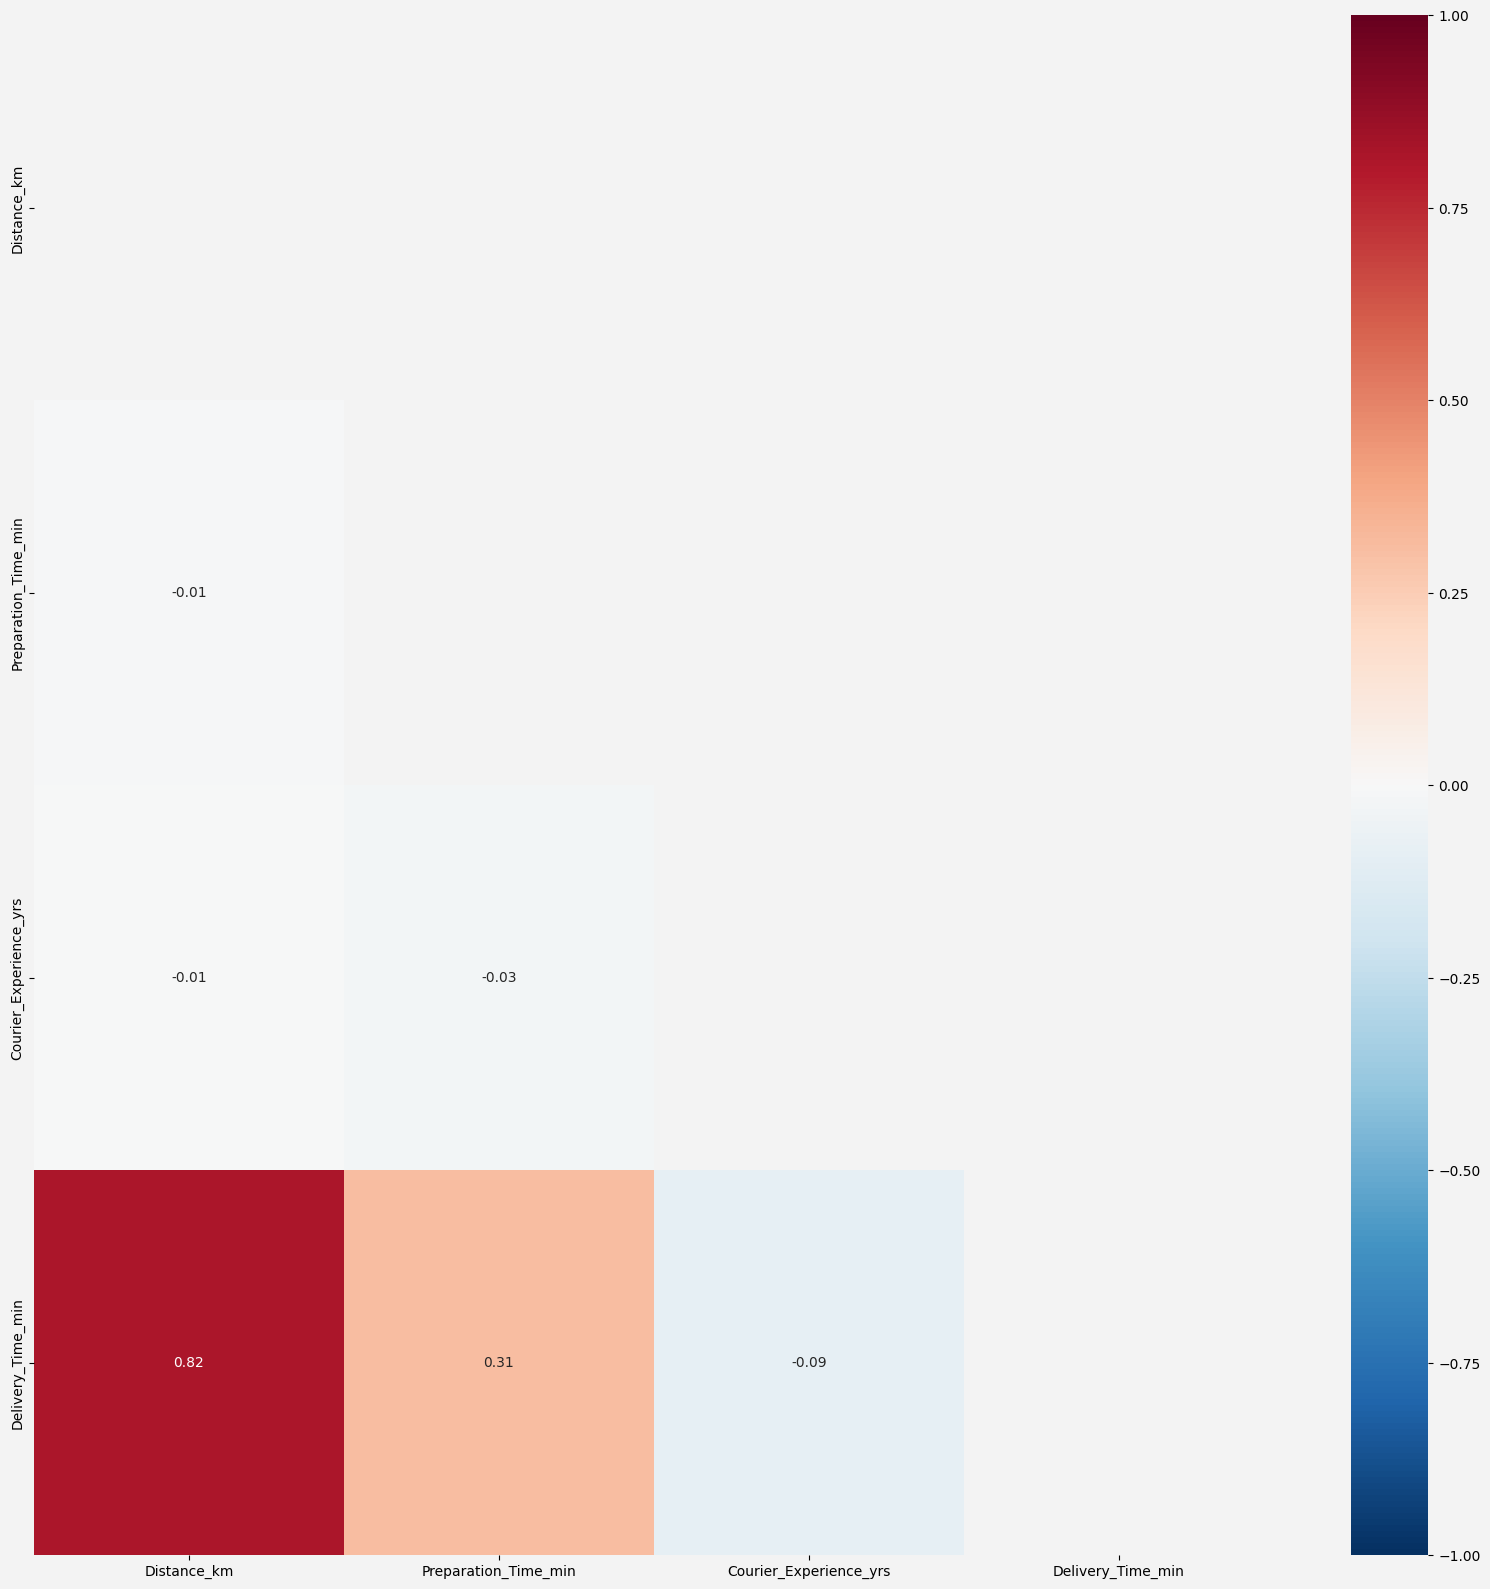

In [ ]:
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 20))
sns.heatmap(
  df_corr,
  vmin = -1,
  vmax = 1,
  annot = True,
  mask = mask,
  fmt = '.2f',
  cmap = 'RdBu_r',
)

Distance_km has high correlation with Delivery_Time_min.

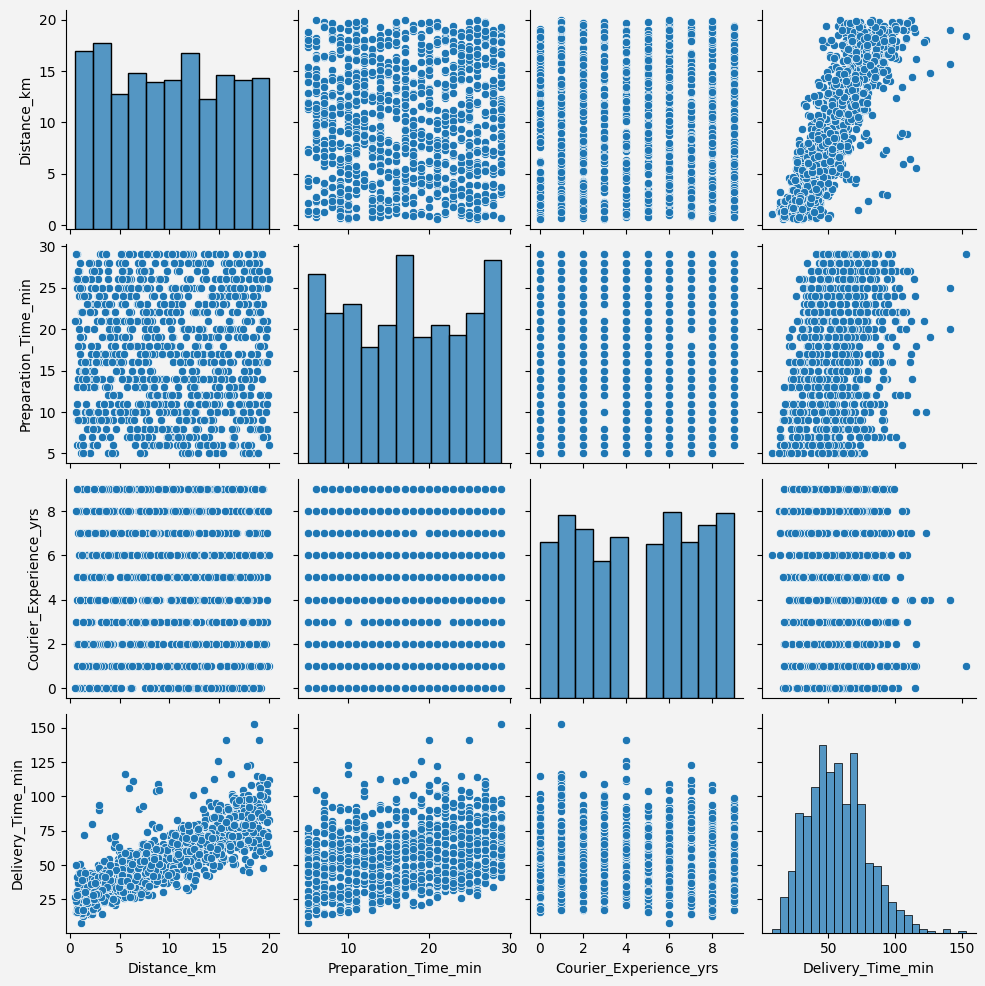

In [ ]:
sns.pairplot(df[numerical_cols])

# Feature Engineering

## Encode categorical features

In [59]:
# Apply ordinal encoding to Trafic_Level column
encoder = OrdinalEncoder(
  categories=[['Low', 'Medium', 'High']],
  handle_unknown='error',
)

X_train['Traffic_Level'] = encoder.fit_transform(X_train[['Traffic_Level']])
X_test['Traffic_Level'] = encoder.transform(X_test[['Traffic_Level']])

In [44]:
# Print mapping
for j, category in enumerate(encoder.categories_[0]):
    print(f"{category} → {j}")

Low → 0
Medium → 1
High → 2


In [60]:
# Apply label encoding to other categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols.drop('Traffic_Level'):
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

    # Print mapping for each label encoded column
    print(f"\nMapping for '{col}':")
    for i, class_label in enumerate(label_encoder.classes_):
        print(f"{class_label} → {i}")


Mapping for 'Weather':
Clear → 0
Foggy → 1
Rainy → 2
Snowy → 3
Windy → 4

Mapping for 'Time_of_Day':
Afternoon → 0
Evening → 1
Morning → 2
Night → 3

Mapping for 'Vehicle_Type':
Bike → 0
Car → 1
Scooter → 2


In [ ]:
X_train.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
29,18.05,0,1.0,1,2,10,7.0
535,2.14,0,2.0,1,0,18,3.0
695,3.23,0,2.0,0,0,17,9.0
557,7.51,2,0.0,1,1,27,6.0
836,4.62,2,1.0,0,1,8,3.0


## Handling multicollinearity

### Calculate VIF scores

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Distance_km,1.003902
2,Weather,1.008403
3,Traffic_Level,1.004078
4,Time_of_Day,1.004919
5,Vehicle_Type,1.005411
6,Preparation_Time_min,1.005160
7,Courier_Experience_yrs,1.009658


There are no multicollinearity.

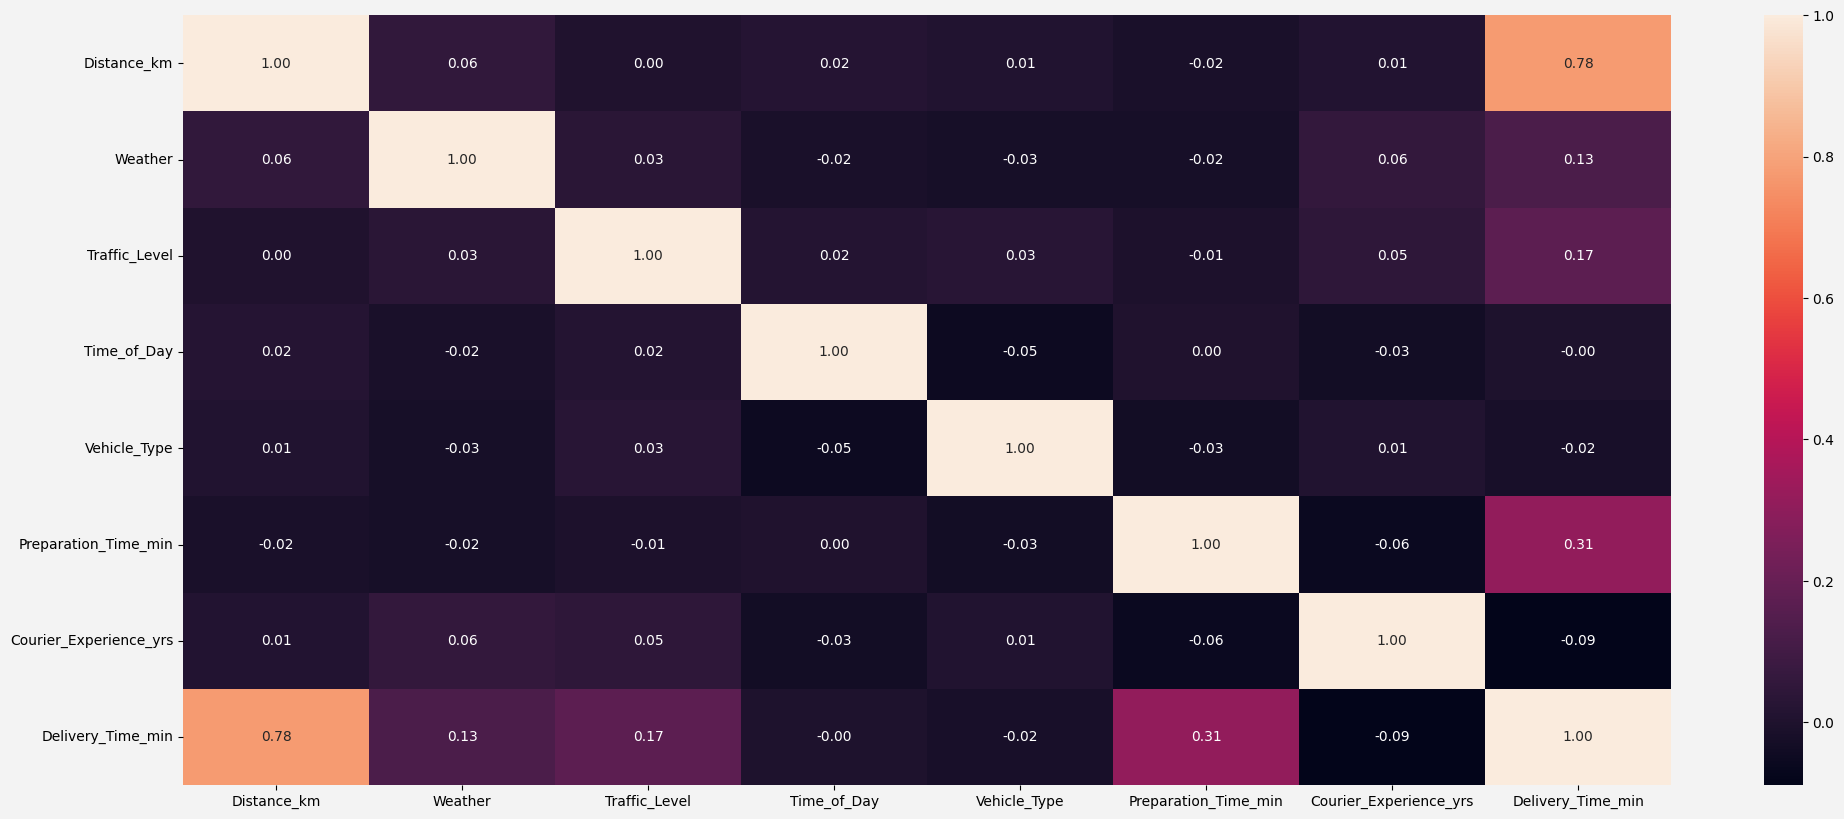

In [ ]:
# Array to dataframe
vif_target_train = pd.DataFrame(y_train, columns=['Delivery_Time_min'])
vif_target_train

# Calculate the correlation
df_train = pd.concat([X_train, vif_target_train], axis=1)
corr = df_train.corr()

# Display the heatmap
plt.figure(figsize=(24,10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

## Scale numeric features

In [61]:
X_train.describe()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,10.10055,1.201250,0.793750,1.216250,0.803750,17.083750,4.618750
std,5.72590,1.395774,0.749609,0.959498,0.871025,7.227519,2.902832
min,0.59000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,5.13000,0.000000,0.000000,0.000000,0.000000,11.000000,2.000000
50%,10.22000,1.000000,1.000000,1.000000,1.000000,17.000000,5.000000
75%,14.94250,2.000000,1.000000,2.000000,2.000000,23.000000,7.000000
max,19.99000,4.000000,2.000000,3.000000,2.000000,29.000000,9.000000


In [62]:
col_to_scale = 'Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs'

In [63]:
Distance_km_scaler = MinMaxScaler()
X_train['Distance_km'] = Distance_km_scaler.fit_transform(X_train[['Distance_km']])
X_test['Distance_km'] = Distance_km_scaler.transform(X_test[['Distance_km']])

In [64]:
Preparation_Time_min_scaler = MinMaxScaler()
X_train['Preparation_Time_min'] = Preparation_Time_min_scaler.fit_transform(X_train[['Preparation_Time_min']])
X_test['Preparation_Time_min'] = Preparation_Time_min_scaler.transform(X_test[['Preparation_Time_min']])

In [65]:
Courier_Experience_yrs_scaler = MinMaxScaler()
X_train['Courier_Experience_yrs'] = Courier_Experience_yrs_scaler.fit_transform(X_train[['Courier_Experience_yrs']])
X_test['Courier_Experience_yrs'] = Courier_Experience_yrs_scaler.transform(X_test[['Courier_Experience_yrs']])

In [66]:
X_train.describe()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.490235,1.201250,0.793750,1.216250,0.803750,0.503490,0.513194
std,0.295149,1.395774,0.749609,0.959498,0.871025,0.301147,0.322537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.234021,0.000000,0.000000,0.000000,0.000000,0.250000,0.222222
50%,0.496392,1.000000,1.000000,1.000000,1.000000,0.500000,0.555556
75%,0.739820,2.000000,1.000000,2.000000,2.000000,0.750000,0.777778
max,1.000000,4.000000,2.000000,3.000000,2.000000,1.000000,1.000000


# Modelling

In [ ]:
len(df[df['Which type of stress do you primarily experience?'] =='No Stress - Currently experiencing minimal to no stress.']) / len(df['Which type of stress do you primarily experience?']) * 100

5.147058823529411

In [ ]:
len(df[df['Which type of stress do you primarily experience?'] =='Eustress (Positive Stress) - Stress that motivates and enhances performance.']) / len(df['Which type of stress do you primarily experience?']) * 100

91.29901960784314

In [ ]:
len(df[df['Which type of stress do you primarily experience?'] =='Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.']) / len(df['Which type of stress do you primarily experience?']) * 100

3.553921568627451

Only 5.1% of students reported no stress, while 91.3% experienced eustress and 3.6% experienced distress.

The dataset is imbalanced. Recall is chosen as the evaluation metric because, although distress cases make up only 3.6% of the data, they are the most critical to identify. Early detection and intervention are essential since distress negatively impacts well-being, contributes to academic burnout, and can escalate into serious mental health problems. Despite being the smallest group, students experiencing distress require the greatest attention.

Since this is a multiclass classification problem with imbalanced data, and the goal is to identify distress, which is a minority class, macro recall is the best option—it ensures that distress receives equal attention, even though it is rare.”

## Linear Regression

In [ ]:
ridge = Ridge()

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

params_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_gridcv = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error', return_train_score = True)
ridge_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# The compact results
ridge_cv_result = pd.DataFrame(ridge_gridcv.cv_results_)
retain_cols = ['params','mean_train_score','mean_test_score','rank_test_score']
ridge_cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_train_score,mean_test_score,rank_test_score
0,{'alpha': 0.01},-124.023173,-126.129603,1
1,{'alpha': 0.1},-124.024295,-126.131569,2
2,{'alpha': 1},-124.132861,-126.249535,3
3,{'alpha': 10},-132.179986,-134.448841,4
4,{'alpha': 100},-268.976870,-272.217153,5


In [ ]:
ridge_gridcv.best_estimator_

Ridge(alpha=0.01)

In [ ]:
# Use best estimator from GridSearchCV
ridge_best_model = ridge_gridcv.best_estimator_

# Predict on test set
ridge_y_pred = ridge_best_model.predict(X_test)

# Calculate metrics
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)

# Print results
print(f"RMSE: {ridge_rmse:.2f}")
print(f"MAE: {ridge_mae:.2f}")
print(f"R² Score: {ridge_r2:.2f}")

RMSE: 9.38
MAE: 6.54
R² Score: 0.80


R² of 0.80 means the model captures most of the signal.

RMSE and MAE are reasonably close, which suggests the errors aren’t dominated by extreme outliers.

The train vs test scores are close (-124 vs -126), meaning low overfitting and the model generalizes well.

In [ ]:
# Get coefficients
ridge_coefficients = ridge_best_model.coef_

# Match with feature names
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})

# Sort by impact
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)

                  Feature  Coefficient
0             Distance_km    58.609371
5    Preparation_Time_min    23.426031
2           Traffic_Level     5.200522
1                 Weather     1.411046
4            Vehicle_Type    -0.447466
3             Time_of_Day    -0.536060
6  Courier_Experience_yrs    -6.384072


## Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Hyperparameter tuning
params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_gridcv = GridSearchCV(rf, params_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score = True)
rf_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# The results
rf_cv_result = pd.DataFrame(rf_gridcv.cv_results_)
retain_cols = ['params','mean_train_score','mean_test_score','rank_test_score']
rf_cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_train_score,mean_test_score,rank_test_score
14,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",-48.463052,-145.217785,1
15,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",-47.515197,-145.264606,2
6,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-47.707896,-145.322486,3
22,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",-47.707896,-145.322486,3
23,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",-46.728719,-145.490549,5
7,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-46.728719,-145.490549,5
12,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",-43.670690,-145.884609,7
4,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-42.714279,-145.912425,8
20,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",-42.714279,-145.912425,8
13,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",-42.635345,-145.993965,10


In [ ]:
rf_gridcv.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

In [ ]:
# Use best estimator from GridSearchCV
rf_best_model = rf_gridcv.best_estimator_

# Predict on test set
rf_y_pred = rf_best_model.predict(X_test)

# Calculate metrics
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

# Print results
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")

RMSE: 9.78
MAE: 6.92
R² Score: 0.79


Random Forest is performing well, but slightly worse than Ridge Regression in terms of RMSE and R².

The gap between train and test scores suggests overfitting.

An R² of 0.79 is strong.

In [ ]:
# Get important feature
importances = rf_best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                  Feature  Importance
0             Distance_km    0.727183
5    Preparation_Time_min    0.153986
6  Courier_Experience_yrs    0.036909
2           Traffic_Level    0.030992
1                 Weather    0.024098
3             Time_of_Day    0.014326
4            Vehicle_Type    0.012506


## ElasticNet

In [ ]:
elastic = ElasticNet(max_iter=10000)

In [ ]:
# Hyperparameter tuning
params_elastic = {
    'alpha': [0.01, 0.1, 1, 10],           # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Mix between Lasso (1.0) and Ridge (0.0)
}

# Grid search with train score
elastic_gridcv = GridSearchCV(
    estimator=elastic,
    param_grid=params_elastic,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit on scaled data
elastic_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# The results
elastic_cv_result = pd.DataFrame(elastic_gridcv.cv_results_)
retain_cols = ['params','mean_train_score','mean_test_score','rank_test_score']
elastic_cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_train_score,mean_test_score,rank_test_score
4,"{'alpha': 0.01, 'l1_ratio': 1.0}",-124.026879,-126.134926,1
3,"{'alpha': 0.01, 'l1_ratio': 0.9}",-124.089441,-126.203894,2
9,"{'alpha': 0.1, 'l1_ratio': 1.0}",-124.394972,-126.524685,3
2,"{'alpha': 0.01, 'l1_ratio': 0.7}",-124.456156,-126.585714,4
1,"{'alpha': 0.01, 'l1_ratio': 0.5}",-125.109830,-127.257060,5
0,"{'alpha': 0.01, 'l1_ratio': 0.1}",-127.132830,-129.321159,6
8,"{'alpha': 0.1, 'l1_ratio': 0.9}",-129.489143,-131.723817,7
7,"{'alpha': 0.1, 'l1_ratio': 0.7}",-149.629140,-152.120412,8
14,"{'alpha': 1, 'l1_ratio': 1.0}",-153.668439,-155.578721,9
6,"{'alpha': 0.1, 'l1_ratio': 0.5}",-172.938922,-175.653959,10


In [ ]:
elastic_gridcv.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=10000)

In [ ]:
# Use best estimator from GridSearchCV
elastic_best_model = elastic_gridcv.best_estimator_

# Predict on test set
elastic_y_pred = elastic_best_model.predict(X_test)

# Calculate metrics
elastic_mse = mean_squared_error(y_test, elastic_y_pred)
elastic_rmse = np.sqrt(elastic_mse)
elastic_mae = mean_absolute_error(y_test, elastic_y_pred)
elastic_r2 = r2_score(y_test, elastic_y_pred)

# Print results
print(f"RMSE: {elastic_rmse:.2f}")
print(f"MAE: {elastic_mae:.2f}")
print(f"R² Score: {elastic_r2:.2f}")

RMSE: 9.37
MAE: 6.54
R² Score: 0.80


RMSE	9.37 is the lowest among all models so far.

MAE	6.54 means low average error.

R² Score	0.80	explains 80% of variance which is excellent fit.

Train/Test Gap	~2.1 indicates good generalization.

In [ ]:
# Get coefficients
elastic_coefficients = elastic_best_model.coef_

# Match with feature names
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': elastic_coefficients})

# Sort by impact
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print(coef_df)

                  Feature  Coefficient
0             Distance_km    58.500374
5    Preparation_Time_min    23.323453
2           Traffic_Level     5.180492
1                 Weather     1.406164
4            Vehicle_Type    -0.434434
3             Time_of_Day    -0.522547
6  Courier_Experience_yrs    -6.288641


## XGBoost

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
# Hyperparameter tuning
params_xgb = {
    'n_estimators': [100, 200],         # Number of trees
    'max_depth': [3, 5, 7],             # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],            # Fraction of samples per tree
    'colsample_bytree': [0.8, 1.0]      # Fraction of features per tree
}

xgb_gridcv = GridSearchCV(
    estimator=xgb,
    param_grid=params_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    verbose=1
)

xgb_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
# The results
xgb_cv_result = pd.DataFrame(xgb_gridcv.cv_results_)
retain_cols = ['params','mean_train_score','mean_test_score','rank_test_score']
xgb_cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_train_score,mean_test_score,rank_test_score
12,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-74.830687,-135.015715,1
13,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-78.374588,-135.413702,2
49,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-76.237022,-135.749013,3
48,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-71.739926,-136.124707,4
14,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-52.586282,-141.245555,5
15,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-57.358485,-141.754253,6
61,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",-51.822332,-142.894485,7
50,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-48.632481,-143.299054,8
51,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",-54.081918,-143.923538,9
16,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-21.886887,-146.061803,10


In [ ]:
xgb_gridcv.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Use best estimator from GridSearchCV
xgb_best_model = xgb_gridcv.best_estimator_

# Predict on test set
xgb_y_pred = xgb_best_model.predict(X_test)

# Calculate metrics
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

# Print results
print(f"RMSE: {elastic_rmse:.2f}")
print(f"MAE: {elastic_mae:.2f}")
print(f"R² Score: {elastic_r2:.2f}")

RMSE: 9.37
MAE: 6.54
R² Score: 0.80


RMSE	9.37 is the same as ElasticNet which is very low error.

MAE	6.54	means tight prediction accuracy.

R² Score	0.80	explains 80% of variance.

Train/Test Gap ~60.2 is larger than Ridge/ElasticNet, but still manageable.

In [ ]:
# Get important feature
importances = xgb_best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                  Feature  Importance
0             Distance_km    0.493604
5    Preparation_Time_min    0.178282
2           Traffic_Level    0.103304
1                 Weather    0.074190
6  Courier_Experience_yrs    0.065340
3             Time_of_Day    0.046362
4            Vehicle_Type    0.038918


# Evaluation

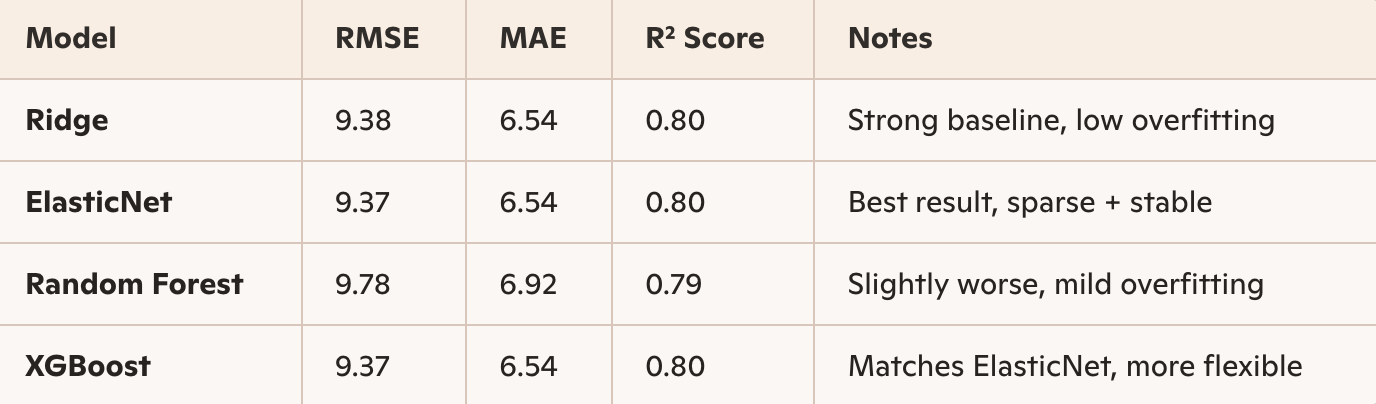

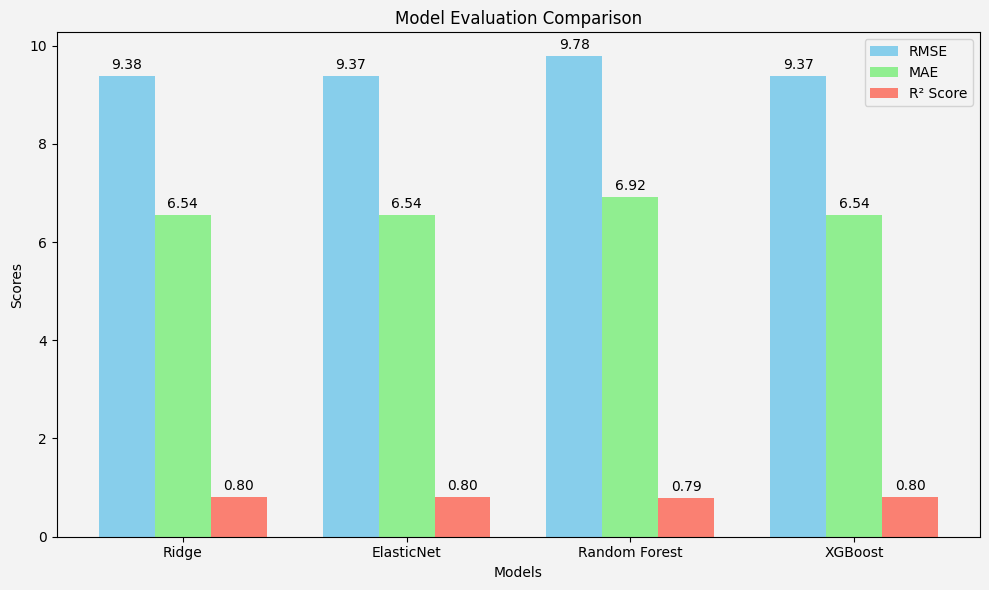

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model names
models = ['Ridge', 'ElasticNet', 'Random Forest', 'XGBoost']

# Evaluation metrics
rmse = [9.38, 9.37, 9.78, 9.37]
mae = [6.54, 6.54, 6.92, 6.54]
r2 = [0.80, 0.80, 0.79, 0.80]

# Bar positions
x = np.arange(len(models))
width = 0.25

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, rmse, width, label='RMSE', color='skyblue')
bars2 = ax.bar(x, mae, width, label='MAE', color='lightgreen')
bars3 = ax.bar(x + width, r2, width, label='R² Score', color='salmon')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display values on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

ElasticNet and XGBoost are tied for best performance (lowest RMSE and highest R²), but XGBoost has higher Train/Test gap.

Ridge is nearly identical in performance, but without feature selection.

Random Forest trails slightly, with higher error and signs of overfitting.

## Save the model

In [ ]:
import joblib

model = elastic_gridcv.best_estimator_

# Save the model to a file
joblib.dump(model, 'best_model.pkl')

['best_model.pkl']

In [ ]:
model = joblib.load('best_model.pkl')
model

ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=10000)

In [71]:
# Save preprocessing tools
joblib.dump(Distance_km_scaler, "Distance_km_scaler.pkl")
joblib.dump(Preparation_Time_min_scaler, "Preparation_Time_min_scaler.pkl")
joblib.dump(Courier_Experience_yrs_scaler, "Courier_Experience_yrs_scaler.pkl")

['Courier_Experience_yrs_scaler.pkl']

In [72]:
scaler = joblib.load('Distance_km_scaler.pkl')
scaler

MinMaxScaler()

In [ ]:
# save df and train/test data
df.to_csv('df.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Recommendation

**Deploy ElasticNet for Delivery Time Prediction**

Use ElasticNet as the primary model given its strong performance.

**Actionable Recommendation**

1. Optimize for Short-Distance Deliveries

Distance has the strongest influence on delivery time (coefficient: +58.5).

Action: Prioritize routing and batching nearby orders. Consider dynamic pricing to encourage short-distance requests.

2. Streamline Preparation Time

Prep time is the second most impactful factor (+23.3).

Action: Improve kitchen workflows, automate order prep alerts, and pre-batch high-frequency items.

3. Deploy Scooters Strategically

Scooters consistently deliver faster with the tightest spread in delivery times.

Action: Assign scooters to high-density zones or time-sensitive deliveries, especially during peak hours.